# TP: Classification challenge with noise
Author: Vadim Lebovici

## Introduction

#### Goal 
Your goal is to perform a supervised classification of a real-world dataset introduced in [this article](https://www.pnas.org/doi/10.1073/pnas.2102166118) which contains point clouds in $\mathbb{R}^2$ obtained from spatial locations of immune cells in tumours. The dataset contains three different types of immune cells:
- CD68 (65 point clouds with average of 560 points, minimum of 88 and maximum of 1000),
- CD8 (73 point clouds with average of 651 points, minimum of 194 and maximum of 1000),
- FoxP3 (74 point clouds with average of 211 points, minimum of 24 and maximum of 499).

You will find examples of point cloud for each class plotted below.

![Illustration of the dataset](fig/dataset.png)

#### Rules
The data is divided into a randomize train/test split of ratio 80/20. Ideally, you would make 20 randomized train/test split and give your average accuracy. Under time constraints, it is already good if do only one train/test split and give the raw accuracy.

Apart from that, you can whatever tool you want: you are free to use other tools than persistence diagrams and you can use any classifier you want.


The following list contains a few ideas for vectorizations of persistence diagrams, but you are free to go on the web and find others:
- Representations from the Gudhi library [[link]](https://gudhi.inria.fr/python/latest/representations.html)
- [Eulearning](https://github.com/vadimlebovici/eulearning) library based on Euler characteristic computations
- [QuPID](https://github.com/majkevh/qupid) algorithm
- [Atol](https://github.com/martinroyer/atol) algorithm


#### Benchmark
Using QuPID, we were able to achieve the following accuracies using a RandomForest classifier:
- CD68 vs CD8: **79.0%**
- CD68 vs FoxP3: **98.2%**
- CD8 vs FoxP3: **96.3%**
- 3-classes classification: **79.4%**

See Table 4 in [our article](https://arxiv.org/abs/2312.17093).

## Code

#### Data

In [3]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Extracting point clouds from data:

In [4]:
# Choose a number of samples for each cell type
# Toy classification to test your tools
n_CD68 = 10
n_CD8 = 10
n_FoxP3 = 10

# To get the full dataset, use the following numbers:
# n_CD68 = 73
# n_CD8 = 65
# n_FoxP3 = 74

Extracting data and adding uniform background noise

In [34]:
n_noise = 500

In [35]:
# Extracting point clouds from files
samplesCD68 = []
for i in range(n_CD68):
    df = pd.read_csv(f"../tp1/data/TumourT_CCD6810NNCodensitySample{i+1}RipsMax1.txt",  skiprows=4, sep=" ", header=None, usecols=[0, 1]).to_numpy()
    noise = np.random.uniform(low=-1.5, high=1.5, size=(n_noise,2))
    X = np.vstack([df, noise])
    samplesCD68.append(X)

samplesCD8 = []
for i in range(n_CD8):
    df = pd.read_csv(f"../tp1/data/TumourT_CCD810NNCodensitySample{i+1}RipsMax1.txt",  skiprows=4, sep=" ", header=None, usecols=[0, 1]).to_numpy()
    noise = np.random.uniform(low=-1.5, high=1.5, size=(n_noise,2))
    X = np.vstack([df, noise])
    samplesCD8.append(X)

samplesFoxP3 = []
for i in range(n_FoxP3):
    df = pd.read_csv(f"../tp1/data/TumourT_CFoxP310NNCodensitySample{i+1}RipsMax1.txt",  skiprows=4, sep=" ", header=None, usecols=[0, 1]).to_numpy()
    noise = np.random.uniform(low=-1.5, high=1.5, size=(n_noise,2))
    X = np.vstack([df, noise])
    samplesFoxP3.append(X)

Plotting examples of point clouds for each class:

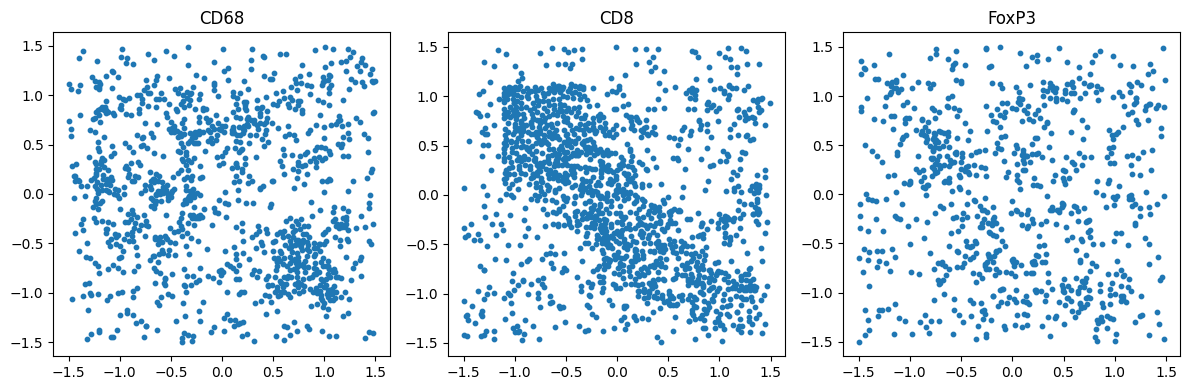

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot first sample of each class
axs[0].scatter(samplesCD68[0][:, 0], samplesCD68[0][:, 1], s=10)
axs[0].set_title('CD68')

axs[1].scatter(samplesCD8[0][:, 0], samplesCD8[0][:, 1], s=10)
axs[1].set_title('CD8')

axs[2].scatter(samplesFoxP3[0][:, 0], samplesFoxP3[0][:, 1], s=10)
axs[2].set_title('FoxP3')

plt.tight_layout()
plt.show()

Now we make a train/test split as required:

In [37]:
# Combine all point clouds into X and create corresponding labels y
X = samplesCD68 + samplesCD8 + samplesFoxP3
y = (
    [0] * len(samplesCD68) +  # Label 0 for CD68
    [1] * len(samplesCD8) +   # Label 1 for CD8
    [2] * len(samplesFoxP3)   # Label 2 for FoxP3
)

In [38]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Convert X and y to a numpy array for easier handling
X_array = np.array(X, dtype=object)  # dtype=object for arrays of different shapes
y_array = np.array(y)

# Shuffle X and y in unison
X_shuffled, y_shuffled = shuffle(X_array, y_array)

# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, stratify=y_shuffled)

#### An example of very bad classification
To give you an example of classification pipeline, I will use summarize each point cloud by the coordinate of the barycenter of the point cloud, and use this vectorization for the classification task using a random forest classifier.

In [39]:
# Compute the barycenter (average coordinates) for each point cloud in X_train and X_test
vectorization_train = np.array([pc.mean(axis=0) for pc in X_train])
vectorization_test = np.array([pc.mean(axis=0) for pc in X_test])

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train RandomForest classifier
clf = RandomForestClassifier()
clf.fit(vectorization_train, y_train)

# Score on test set
vectorization_score = clf.score(vectorization_test, y_test)
print(f"Test accuracy: {vectorization_score:.2f}")

Test accuracy: 0.17


We get an accuracy between 30% and 40% which is close to the score 33% that we would obtain by guessing at random without any information. This shows that my choice of vectorization is very bad.

#### The floor is yours:

In [ ]:
# Your classification pipeline...

# Bonus:
What does a PCA combined with a clustering algorithm give with you vectorization? Would it be good enough to allow for unsupervised classification of the point cloud?